# **Setup**

In [ ]:
import torch
import torch_geometric
from torch_geometric.data import Data
import rdkit
import rdkit.Chem as Chem
import numpy as np
import rdkit.Chem.AllChem as AllChem
import pandas as pd
import joblib
import io

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:18: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: libtorch_cuda_cpp.so: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:31: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops6narrow4callERKNS_6TensorElll
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:42: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_sparse/_diag_cuda.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warnings.warn(f"An issue occurr

# **Import your SMILES file from the local**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving nr-ar-lbd.smiles to nr-ar-lbd.smiles


In [ ]:
pubchem= pd.read_csv(io.StringIO(uploaded['nr-ar-lbd.smiles'].decode('utf-8')),sep='\t',names=['SMILES','Sample ID','Activity'])


In [ ]:
pubchem

,SMILES,Sample ID,Activity
0,Cl.CC(NCCC(C1=CC=CC=C1)C2=CC=CC=C2)C3=CC=CC=C3,NCGC00094891-01,0
1,OC1=C([Hg]Cl)C=CC=C1,NCGC00181158-01,1
2,FC(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F.CCCCCCC...,NCGC00258157-01,0
3,COC1=CC=C(CCN2CCC(CC2)NC3=NC4=CC=CC=C4N3CC5=CC...,NCGC00016913-08,0
4,Cl.CCCOC1=C(Br)C(C)=C(S1)C(=O)N2CCC(CC2)C3=CC(...,NCGC00254244-01,1
...,...,...,...
8594,CCCC1=CC(=O)NC(=S)N1,NCGC00259290-01,0
8595,S=C1NCCN1,NCGC00258846-01,0
8596,S=C1NCCN1,NCGC00254936-01,0
8597,CCOP(=S)(OCC)OC1=CC=C(C=C1)[N+]([O-])=O,NCGC00254571-01,0


# **Check which atoms elements are inside**

In [ ]:
def check_atoms(mol):
  """
  This function checks whether all atoms are valid
  """
  valid_atoms = ('H', 'B', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl',
                 'Br','I','Se','Si','Ge','As','Sb')
  # valid_atoms = ('H', 'B', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl')
  flag = True
  for atm in mol.GetAtoms():
    if atm.GetSymbol() not in valid_atoms:
      flag = False
      break
  return flag

# **Setup for SMILES file, before jump into graph representation from smiles, we should check if the data is clean, friendly to rdkit, check some aromaticity issue and so on**

In [ ]:
from tqdm import tqdm
activity = []
disregarded_data=[]
index=[]


i=-1
for smi, score, ID in tqdm(zip(pubchem["SMILES"], pubchem["Activity"],pubchem["Sample ID"])):
  i+=1
  mol = Chem.MolFromSmiles(smi) #sanitize=False
  if not mol:
    disregarded_data.append(ID)
    index.append(i)
    continue
  if check_atoms(mol): #
    activity.append((mol, score))
  else:
    disregarded_data.append(ID)
    index.append(i)
    continue

1297it [00:00, 2632.81it/s][17:13:31] Explicit valence for atom # 3 Si, 8, is greater than permitted
2093it [00:00, 3487.99it/s][17:13:31] Explicit valence for atom # 0 Cl, 2, is greater than permitted
4197it [00:01, 5031.47it/s][17:13:31] Explicit valence for atom # 2 Cl, 2, is greater than permitted
4850it [00:01, 5485.98it/s][17:13:31] WARNING: not removing hydrogen atom without neighbors
6228it [00:01, 4766.92it/s][17:13:32] Explicit valence for atom # 3 Si, 8, is greater than permitted
8599it [00:01, 4865.74it/s]


In [ ]:
disregarded_data=pd.DataFrame(disregarded_data)
index=pd.DataFrame(index)
disregarded=pd.DataFrame

disregarded=pd.concat([disregarded_data,index],axis=1)
disregarded.columns=['Sample ID','Index']
print(len(disregarded))
print(len(activity))
# print(disregarded)

489
8110


In [ ]:
# pubchem_dropped = pubchem.drop(index)

# disregarded.to_csv("NR_PPAR_gamma_disregarded.txt",index=False,sep='\t')
# pubchem_dropped.to_csv("NR_PPAR_gamma_preprocessed.txt",index=False,sep='\t')

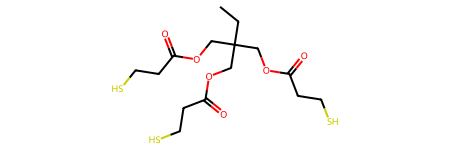

In [ ]:
mol

### Hybridization types in RDKit
----
https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.HybridizationType

### How to convert to 2D graph (U can also do 3D graph representation), and allow the Torch package to understand how it looks (torch.tensor format)

In [ ]:
def convert_mol_to_graph(mol, use_pos = False):

    mol2 = Chem.AddHs(mol) #
    n_bonds = len(mol2.GetBonds()) # N of bonds
    n_atoms = len(mol2.GetAtoms()) # Atomic Numbers

    edge_index = []
    edge_attr = []
    edge_weight = []
    for edge_idx in range(n_bonds):
        bond = mol2.GetBondWithIdx(edge_idx)
        edge_index.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
        edge_index.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]) # Make Undirected Graph format

        # BondType (4-dimensional one-hot)
        btype = bond.GetBondType() # Types of covalent bond
        if btype == Chem.rdchem.BondType.SINGLE:
            bond_one_hot = [1, 0, 0, 0]
            edge_weight.extend([1.0, 1.0])
        elif btype == Chem.rdchem.BondType.AROMATIC:
            bond_one_hot = [0, 1, 0, 0]
            edge_weight.extend([1.5, 1.5])
        elif btype == Chem.rdchem.BondType.DOUBLE:
            bond_one_hot = [0, 0, 1, 0]
            edge_weight.extend([2.0, 2.0])
        elif btype == Chem.rdchem.BondType.TRIPLE:
            bond_one_hot = [0, 0, 0, 1]
            edge_weight.extend([3.0, 3.0])

        # BondStereo (6-dimensional one-hot)
        stype = bond.GetStereo()
        if stype == Chem.rdchem.BondStereo.STEREOANY:
          stereo_one_hot = [1, 0, 0, 0, 0, 0]
        elif stype == Chem.rdchem.BondStereo.STEREOCIS:
          stereo_one_hot = [0, 1, 0, 0, 0, 0]
        elif stype == Chem.rdchem.BondStereo.STEREOE:
          stereo_one_hot = [0, 0, 1, 0, 0, 0]
        elif stype == Chem.rdchem.BondStereo.STEREONONE:
          stereo_one_hot = [0, 0, 0, 1, 0, 0]
        elif stype == Chem.rdchem.BondStereo.STEREOTRANS:
          stereo_one_hot = [0, 0, 0, 0, 1, 0]
        elif stype == Chem.rdchem.BondStereo.STEREOZ:
          stereo_one_hot = [0, 0, 0, 0, 0, 1]

        # Is this bond included in a ring?
        if bond.IsInRing():
          ring_bond = 1
        else:
          ring_bond = 0

        # Is this bond a conjugated bond?
        if bond.GetIsConjugated():
          conjugate = 1
        else:
          conjugate = 0
        # In total 12-dimensional edge attribute
        # bond-type (4-dim), bondstereo (6-dim), (ring, conjugate)
        # Can you image more?
        attr = bond_one_hot + stereo_one_hot + [ring_bond, conjugate] # 12 dimensions


        edge_attr.append(attr)
        edge_attr.append(attr)
    ##


    # https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.Atom
    #
    #.        0.   1.   2.   3.   4.   5.   6.   7.   8.
    #        'H', 'B', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl'
    valid_atoms = {'H': 0, 'B':1, 'C':2, 'N':3, 'O':4, 'F':5, 'P':6, 'S':7, 'Cl':8,
                   'Br':9, 'I':10, 'Se':11, 'Si': 12, 'Ge': 13, 'As': 14, 'Sb':15}
    # valid_atoms = {'H': 0, 'B':1, 'C':2, 'N':3, 'O':4, 'F':5, 'P':6, 'S':7, 'Cl':8}

    node_attr = []
    for atm_id in range(n_atoms):
        # Select an atom.
        atm = mol2.GetAtomWithIdx(atm_id)

        # Atom symbol check (9-dim)
        sym = atm.GetSymbol()
        atm_one_hot = [0] * len(valid_atoms)
        idx = valid_atoms[sym]
        atm_one_hot[idx] = 1

        # Check hybridization (7-dim)
        hybrid = atm.GetHybridization()
        hybrid_one_hot = [0] * 7 # [0, 0, 0, 0, 0, 0, 0]
        if hybrid == Chem.HybridizationType.SP3:
          hybrid_one_hot[0] = 1
        elif hybrid == Chem.HybridizationType.SP2:
          hybrid_one_hot[1] = 1
        elif hybrid == Chem.HybridizationType.SP:
          hybrid_one_hot[2] = 1
        elif hybrid == Chem.HybridizationType.S:
          hybrid_one_hot[3] = 1
        elif hybrid == Chem.HybridizationType.SP3D:
          hybrid_one_hot[4] = 1
        elif hybrid == Chem.HybridizationType.SP3D2:
          hybrid_one_hot[5] = 1
        else:
          hybrid_one_hot[6] = 1

        # aromatic   (True/False)
        if atm.GetIsAromatic():
          arom = 1
        else:
          arom = 0

        # ring (True/False)
        if atm.IsInRing():
          ring_flag = 1
        else:
          ring_flag = 0

        # Degree  (6-dim, one-hot)
        # 0, 1, 2, 3, 4, >=5
        degree_one_hot = [0, 0, 0, 0, 0, 0]
        degree = atm.GetTotalDegree()
        if degree >= 5:
          degree_one_hot[5]=1
        else:
          degree_one_hot[degree]=1

        num_h = atm.GetTotalNumHs()
        hydrogen_one_hot = [0, 0, 0, 0, 0]
        if num_h >= 4:
          hydrogen_one_hot[4] = 1
        else:
          hydrogen_one_hot[num_h] = 1

        # Chirality (4-dim, one-hot)
        chiral = atm.GetChiralTag()
        if chiral == Chem.rdchem.ChiralType.CHI_OTHER:
          chiral_one_hot = [1, 0, 0, 0]
        # Counter-clock-wise
        elif chiral == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW:
          chiral_one_hot = [0, 1, 0, 0]
        # Clockwise
        elif chiral == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW:
          chiral_one_hot = [0, 0, 1, 0]
        # Chirality
        elif chiral == Chem.rdchem.ChiralType.CHI_UNSPECIFIED:
          chiral_one_hot = [0, 0, 0, 1]

        # in total 25-dim.

        # 9-dim, 7-dim, 6-dim, 5-dim, 4-dim, 4-dim = 35-dim
        attr = atm_one_hot + hybrid_one_hot + \
                degree_one_hot + hydrogen_one_hot + \
                chiral_one_hot + \
                [arom, ring_flag, atm.GetFormalCharge(), atm.GetNumRadicalElectrons()]

        #print(atm_id, attr)
        node_attr.append(attr)


    edge_attr = torch.tensor(edge_attr, dtype = torch.float)
    node_attr = torch.tensor(node_attr, dtype = torch.float)
    edge_index = torch.tensor(edge_index, dtype = torch.long)
    edge_index = edge_index.t().contiguous()
    edge_weight = torch.tensor(edge_weight, dtype = torch.float)

    if use_pos: # in the case, using 3D corrdinates
        val = AllChem.EmbedMolecule(mol2)
        if val !=0:
          print(f"Error while generating 3D: {Chem.MolToSmiles(mol)}")
          return None

        pos_list = [] # this is optional
        for atm_id in range(n_atoms):
          # Get Atomic Position.
          atm_pos = mol2.GetConformer(0).GetAtomPosition(atm_id)
          crd = [atm_pos.x, atm_pos.y, atm_pos.z]
          pos_list.append(crd)

        pos = torch.tensor(pos_list, dtype=torch.float)
    else:
      pos = None
    #print(edge_attr.shape)
    #print(node_attr.shape)
    #print(edge_index.shape)

    return edge_index, node_attr, edge_attr, pos, edge_weight

In [ ]:
edge_index, x, edge_attr, pos, edge_weight = convert_mol_to_graph(activity[0][0])

In [ ]:
edge_index

tensor([[ 1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,  9, 10,
         10, 11, 11, 12,  6, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18,  2, 19,
         19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 12,  7, 18, 13, 24, 19,  0, 25,
          1, 26,  1, 27,  1, 28,  2, 29,  3, 30,  4, 31,  4, 32,  5, 33,  5, 34,
          6, 35,  8, 36,  9, 37, 10, 38, 11, 39, 12, 40, 14, 41, 15, 42, 16, 43,
         17, 44, 18, 45, 20, 46, 21, 47, 22, 48, 23, 49, 24, 50],
        [ 2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8, 10,  9,
         11, 10, 12, 11, 13,  6, 14, 13, 15, 14, 16, 15, 17, 16, 18, 17, 19,  2,
         20, 19, 21, 20, 22, 21, 23, 22, 24, 23,  7, 12, 13, 18, 19, 24, 25,  0,
         26,  1, 27,  1, 28,  1, 29,  2, 30,  3, 31,  4, 32,  4, 33,  5, 34,  5,
         35,  6, 36,  8, 37,  9, 38, 10, 39, 11, 40, 12, 41, 14, 42, 15, 43, 16,
         44, 17, 45, 18, 46, 20, 47, 21, 48, 22, 49, 23, 50, 24]])

In [ ]:
d0 = Data(x = x, edge_index = edge_index, edge_attr = edge_attr, pos = pos, edge_weight = edge_weight)

In [ ]:
d0

# valid_atoms = {'H': 0, 'B':1, 'C':2, 'N':3, 'O':4, 'F':5, 'P':6, 'S':7, 'Cl':8,'Br':9, 'I':10, 'Se':11, 'Si': 12, 'Ge': 13, 'As': 14, 'Sb':15}

Data(x=[51, 42], edge_index=[2, 104], edge_attr=[104, 12], edge_weight=[104])

In [ ]:
x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
#Torch Geometric
data_list = []
for mol, score in tqdm(activity):
    result = convert_mol_to_graph(mol)
    if result is None:
        continue
    edge_index, node_attr, edge_attr, pos, edge_weight = result
    y = torch.tensor([[score]], dtype = torch.float)
    dtmp = Data(x = node_attr, pos = pos, edge_index = edge_index, edge_attr = edge_attr, edge_weight = edge_weight, y = y)
    data_list.append(dtmp)

100%|██████████| 8110/8110 [00:12<00:00, 668.16it/s] 


In [ ]:
from torch_geometric.loader import DataLoader

## Apply some sampling technique so my testdata set does not go biased, as you can see, the dataset itself is highly biased. active data point (which represent 1) have really small portion among the whole dataset


In [ ]:
#Apply Stratified Sampling

from sklearn.model_selection import StratifiedShuffleSplit
from torch_geometric.loader import DataLoader

# Create a list of activity scores
y = [data.y.item() for data in data_list]

# Use StratifiedShuffleSplit to perform stratified sampling
sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=10000)
train_val_idx, test_idx = next(sss_train_val.split(data_list, y))

# Split the data into train+val and test sets
train_val_set = [data_list[i] for i in train_val_idx]
test_set = [data_list[i] for i in test_idx]

# Use StratifiedShuffleSplit again to split the train+val set into train and val sets
sss_train = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=10000)
train_idx, val_idx = next(sss_train.split(train_val_set, [data.y.item() for data in train_val_set]))

# Split the train+val set into train and val sets
train_set = [train_val_set[i] for i in train_idx]
val_set = [train_val_set[i] for i in val_idx]

total=len(data_list)
print(len(train_set)/total)
print(len(val_set)/total)
print(len(test_set)/total)
act_y_train=[data.y.item()for data in train_set]
print(act_y_train.count(1.0)/len(train_set)*100)
act_y_val=[data.y.item()for data in val_set]
print(act_y_val.count(1.0)/len(val_set)*100)
act_y_test=[data.y.item() for data in test_set]
print(act_y_test.count(1.0)/len(act_y_test)*100)

0.8099876695437731
0.09001233045622688
0.1
3.425178870452124
3.4246575342465753
3.45252774352651


In [ ]:
train_set[0]

Data(x=[24, 42], edge_index=[2, 48], edge_attr=[48, 12], y=[1, 1], edge_weight=[48])

In [ ]:
print(train_set)

[Data(x=[24, 42], edge_index=[2, 48], edge_attr=[48, 12], y=[1, 1], edge_weight=[48]), Data(x=[36, 42], edge_index=[2, 76], edge_attr=[76, 12], y=[1, 1], edge_weight=[76]), Data(x=[43, 42], edge_index=[2, 88], edge_attr=[88, 12], y=[1, 1], edge_weight=[88]), Data(x=[29, 42], edge_index=[2, 60], edge_attr=[60, 12], y=[1, 1], edge_weight=[60]), Data(x=[24, 42], edge_index=[2, 48], edge_attr=[48, 12], y=[1, 1], edge_weight=[48]), Data(x=[35, 42], edge_index=[2, 68], edge_attr=[68, 12], y=[1, 1], edge_weight=[68]), Data(x=[25, 42], edge_index=[2, 52], edge_attr=[52, 12], y=[1, 1], edge_weight=[52]), Data(x=[25, 42], edge_index=[2, 48], edge_attr=[48, 12], y=[1, 1], edge_weight=[48]), Data(x=[41, 42], edge_index=[2, 82], edge_attr=[82, 12], y=[1, 1], edge_weight=[82]), Data(x=[29, 42], edge_index=[2, 60], edge_attr=[60, 12], y=[1, 1], edge_weight=[60]), Data(x=[72, 42], edge_index=[2, 146], edge_attr=[146, 12], y=[1, 1], edge_weight=[146]), Data(x=[41, 42], edge_index=[2, 84], edge_attr=[84

In [ ]:
train_loader = DataLoader(train_set, batch_size=100, shuffle=True, drop_last = False)
test_loader = DataLoader(test_set, batch_size=100, shuffle=True, drop_last = False)
val_loader = DataLoader(val_set, batch_size=100, shuffle=False, drop_last = False)

In [ ]:
for batch in train_loader:
    print(batch)
    print(batch.batch)
    print(batch.num_graphs)
    print(batch.num_node_features)
    break

DataBatch(x=[3457, 42], edge_index=[2, 7016], edge_attr=[7016, 12], y=[100, 1], edge_weight=[7016], batch=[3457], ptr=[101])
tensor([ 0,  0,  0,  ..., 99, 99, 99])
100
42


In [ ]:
data = data_list[0]
data2=data_list[1]
print(data.keys)
print(data2.keys)
print(data2)
print(data)

['x', 'edge_weight', 'edge_attr', 'edge_index', 'y']
['x', 'edge_weight', 'edge_attr', 'edge_index', 'y']
Data(x=[95, 42], edge_index=[2, 186], edge_attr=[186, 12], y=[1, 1], edge_weight=[186])
Data(x=[51, 42], edge_index=[2, 104], edge_attr=[104, 12], y=[1, 1], edge_weight=[104])


In [ ]:
data.num_node_features

42

# **Build some Deep learning architecture**

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import MFConv

from torch_geometric.nn import GATv2Conv

from torch_geometric.nn import global_mean_pool
class myGCN1(torch.nn.Module):
    def __init__(self, in_channel=42, hidden_layer_size=84):
        super().__init__()
        self.conv1 = GATConv(in_channel, hidden_layer_size)
        self.conv2 = GATConv(hidden_layer_size, hidden_layer_size)
        self.conv3 = GATConv(hidden_layer_size, hidden_layer_size)
        # self.conv4 = GATConv(hidden_layer_size, hidden_layer_size)
        #self.conv5 = GCNConv(hidden_layer_size, hidden_layer_size)
        self.lin1 = Linear(hidden_layer_size, int(hidden_layer_size/2))
        self.lin2 = Linear(int(hidden_layer_size/2), 1)

    def forward(self, data):
        x, edge_index, batch, edge_weight = data.x, data.edge_index, data.batch, data.edge_weight

        x = self.conv1(x, edge_index)
        x = F.mish(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.mish(x)

        x = self.conv3(x, edge_index)
        x = F.mish(x)

        # x = self.conv4(x, edge_index)
        # x = F.mish(x)

        #x = self.conv5(x, edge_index)
        #x = F.elu(x)

        # READOUT
        x = global_mean_pool(x, batch)
        x = self.lin1(x) # 70 dim -> 35-dim
        x = F.mish(x)
        x = self.lin2(x) # 35 dim -> 1-dim

        return torch.sigmoid(x)
        # return x




### Another customized GCNN architecture


In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import MFConv

from torch_geometric.nn import GATv2Conv

from torch_geometric.nn import global_mean_pool
class myGCN(torch.nn.Module):
    def __init__(self, in_channel=42, hidden_layer_size=84):
        super().__init__()
        self.conv1 = GATConv(in_channel, hidden_layer_size)
        self.conv2 = GATConv(hidden_layer_size, hidden_layer_size)
        self.conv3 = GATConv(hidden_layer_size, hidden_layer_size)
        # self.conv4 = GATConv(hidden_layer_size, hidden_layer_size)
        #self.conv5 = GCNConv(hidden_layer_size, hidden_layer_size)
        self.lin1 = Linear(hidden_layer_size, int(hidden_layer_size/2))
        self.lin2 = Linear(int(hidden_layer_size/2), 1)

    def forward(self, data):
        x, edge_index, batch, edge_weight = data.x, data.edge_index, data.batch, data.edge_weight

        x = self.conv1(x, edge_index)
        x = F.gelu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.gelu(x)

        x = self.conv3(x, edge_index)
        x = F.gelu(x)

        # x = self.conv4(x, edge_index)
        # x = F.mish(x)

        #x = self.conv5(x, edge_index)
        #x = F.elu(x)

        # READOUT
        x = global_mean_pool(x, batch) # 전체의 node feature의 평균 값을 취한다. # [batch_size, hidden_channels]
        x = self.lin1(x) # 70 dim -> 35-dim
        x = F.elu(x)
        x = self.lin2(x) # 35 dim -> 1-dim

        return torch.sigmoid(x)
        # return x


In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    # print("Try GPU AGain")

print(device)
model = myGCN1()
model.to(device)

cuda


myGCN1(
  (conv1): GATConv(42, 84, heads=1)
  (conv2): GATConv(84, 84, heads=1)
  (conv3): GATConv(84, 84, heads=1)
  (lin1): Linear(in_features=84, out_features=42, bias=True)
  (lin2): Linear(in_features=42, out_features=1, bias=True)
)

In [ ]:
print(model)
print(count_parameters(model))

myGCN1(
  (conv1): GATConv(42, 84, heads=1)
  (conv2): GATConv(84, 84, heads=1)
  (conv3): GATConv(84, 84, heads=1)
  (lin1): Linear(in_features=84, out_features=42, bias=True)
  (lin2): Linear(in_features=42, out_features=1, bias=True)
)
+----------------------+------------+
|       Modules        | Parameters |
+----------------------+------------+
|    conv1.att_src     |     84     |
|    conv1.att_dst     |     84     |
|      conv1.bias      |     84     |
| conv1.lin_src.weight |    3528    |
|    conv2.att_src     |     84     |
|    conv2.att_dst     |     84     |
|      conv2.bias      |     84     |
| conv2.lin_src.weight |    7056    |
|    conv3.att_src     |     84     |
|    conv3.att_dst     |     84     |
|      conv3.bias      |     84     |
| conv3.lin_src.weight |    7056    |
|     lin1.weight      |    3528    |
|      lin1.bias       |     42     |
|     lin2.weight      |     42     |
|      lin2.bias       |     1      |
+----------------------+------------+
T

### Apply optimization, scheduling function


In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR


optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# criterion = torch.nn.MSELoss()

criterion = torch.nn.BCELoss()

scheduler = StepLR(optimizer, step_size=50, gamma=0.8)


In [ ]:

from sklearn.metrics import roc_auc_score

def test(loader):
    model.eval()
    out_all = []
    true = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.to(device))
        out_all.extend([x.item() for x in out])
        true.extend([x.item() for x in data.y])

    auc_roc = roc_auc_score(true, out_all)
    return auc_roc, out_all, true

In [ ]:
def train():
    model.train()
    for idx, batch in enumerate(train_loader):
        out = model(batch.to(device))
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        if idx%100 == 0:
            print(f"IDX: {idx:5d}\tLoss: {loss:.4f}")

In [ ]:
#Scheduler

def train():
    model.train()
    for idx, batch in enumerate(train_loader):
        out = model(batch.to(device))
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        if idx%100 == 0:
            lr = scheduler.get_last_lr()
            print(f"IDX: {idx:5d}\tLoss: {loss:.4f}\tLR: {lr}")
    scheduler.step() # Scheduler \

In [ ]:
!python --version

Python 3.10.12


In [ ]:
def test(loader):
    model.eval()
    out_all = []
    true = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.to(device))
        out_all.extend([x.item() for x in out])
        true.extend([x.item() for x in data.y])

    auc_roc = roc_auc_score(true, out_all)
    return auc_roc, out_all, true

Hit the code, and see how the accuracy improves, increase the size of the epoch, and see how it goes

In [ ]:
train_acc_list = []
val_acc_list = []
test_acc_list = []
for epoch in range(1, 50 ):
    print("="*100)
    print("Epoch: ", epoch)

    train()

    train_acc, out_tmp, true_tmp = test(train_loader)
    train_acc_list.append(train_acc)

    test_acc, out_all, true_all = test(test_loader)
    test_acc_list.append(test_acc)

    val_acc, val_pred, val_true = test(val_loader)
    val_acc_list.append(val_acc)

    print("-"*100)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch:  1
IDX:     0	Loss: 0.7093	LR: [0.0005]
----------------------------------------------------------------------------------------------------
Epoch: 001, Train Acc: 0.6242, Val Acc: 0.6491, Test Acc: 0.5300
Epoch:  2
IDX:     0	Loss: 0.2636	LR: [0.0005]
----------------------------------------------------------------------------------------------------
Epoch: 002, Train Acc: 0.7727, Val Acc: 0.7871, Test Acc: 0.6392
Epoch:  3
IDX:     0	Loss: 0.1979	LR: [0.0005]
----------------------------------------------------------------------------------------------------
Epoch: 003, Train Acc: 0.7938, Val Acc: 0.7875, Test Acc: 0.6576
Epoch:  4
IDX:     0	Loss: 0.1304	LR: [0.0005]
----------------------------------------------------------------------------------------------------
Epoch: 004, Train Acc: 0.7982, Val Acc: 0.7799, Test Acc: 0.6735
Epoch:  5
IDX:     0	Loss: 0.1248	LR: [0.0005]
----------------------------------------------------------------------------------------------------


## Plot Loss function
----


In [ ]:
import matplotlib.pyplot as plt
def draw_loss_change(train_loss, val_loss, test_loss):
  plt.figure(figsize=(8,8)) #
  plt.plot(train_loss, color = 'r', label = 'Train loss') # training loss
  plt.plot(val_loss, color = 'b', label = 'Val loss') # validation set loss
  plt.plot(test_loss, color = 'g',  label = 'Test loss') # test set loss
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best') # label

In [ ]:
true_activity=[]
true_index=[]
out_activity=[]
for index,element in enumerate(true_all):
  if element ==1.0:
    true_index.append(index)

for element in true_index:
  out_activity.append(out_all[element])


len(true_all)
len(out_all)
print(out_activity)
# print(true_all)

[0.020068788900971413, 0.42417165637016296, 0.010136247612535954, 0.5508865714073181, 0.025499938055872917, 0.01527476403862238, 0.01343561615794897, 0.5011693835258484, 0.025499938055872917, 0.054232072085142136, 0.8672713041305542, 0.961949348449707, 0.8757907748222351, 0.0547558069229126, 0.9509322643280029, 0.006570779252797365, 0.7957326769828796, 0.9448598027229309, 0.016438744962215424, 0.013888906687498093, 0.6892999410629272, 0.8977962732315063, 0.7517711520195007, 0.9004024863243103, 0.31028592586517334, 0.9418206214904785, 0.027016952633857727, 0.01684756763279438]


In [ ]:
import matplotlib.pyplot as plt
def draw_loss_change(train_loss, val_loss, test_loss):
  plt.figure(figsize=(8,8))
  plt.plot(train_loss, color = 'r', label = 'Train loss') # training loss
  plt.plot(val_loss, color = 'b', label = 'Val loss') # validation set loss
  plt.plot(test_loss, color = 'g',  label = 'Test loss') # test set loss
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  # plt.savefig('Loss_SR_ATAD5.png')



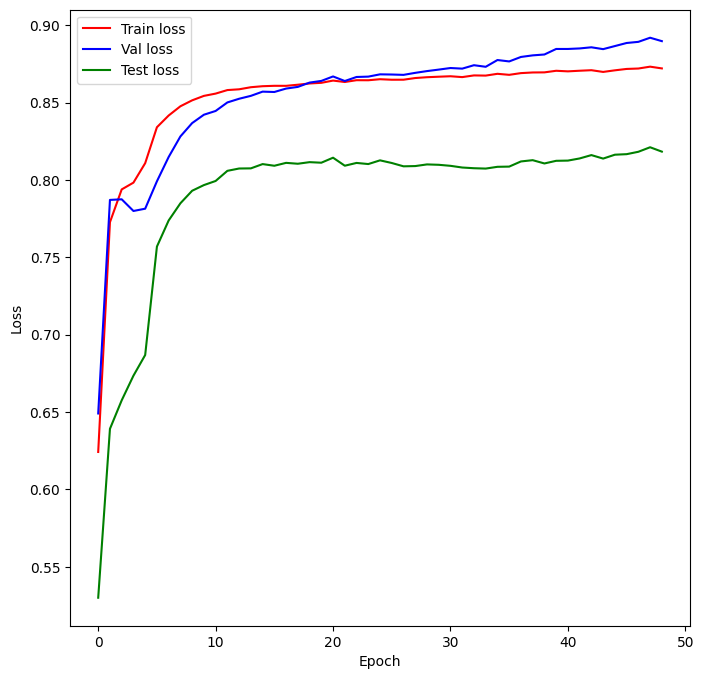

In [ ]:
draw_loss_change(train_acc_list, val_acc_list, test_acc_list)


Evaluate the metrics with ROC score

In [ ]:
# corr = np.corrcoef(true_all, out_all)
roc= roc_auc_score(true_all, out_all)

# roc= roc_auc_score(true_all, out_all)
# corr=np.corrcoef(out_all,true_all)
# print(corr)
print(roc)
# matthews_corrcoef(experimental,prediction)

0.818258529465426


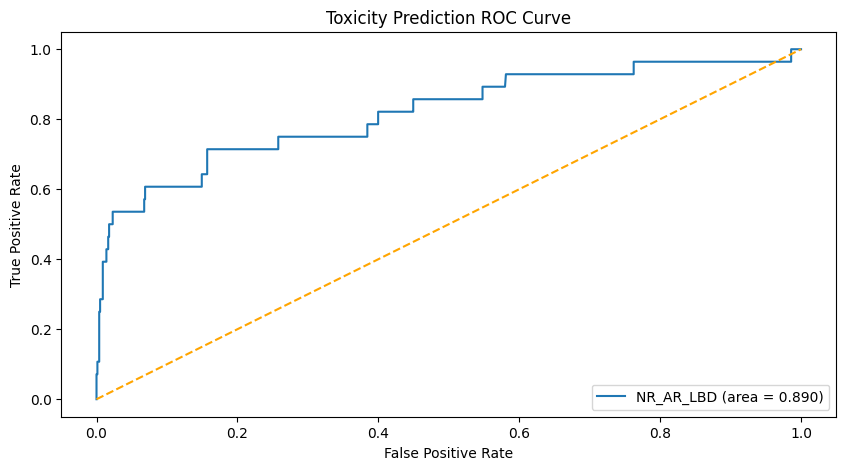

<Figure size 640x480 with 0 Axes>

In [ ]:
#Plot ROC
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
#fpr, tpr,thresholds=roc_curve(y_test,pred_positive_label)
#precisions, recalls, thresholds =roc+curve

FPR, TPR, thresholds = roc_curve(true_all,out_all)


plt.figure(figsize=(10,5))
plt.plot(FPR,TPR)
plt.legend(['NR_AR_LBD (area = 0.890)'],loc="lower right")
plt.plot([0,1],[0,1],'--',color="orange")
plt.title("Toxicity Prediction ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# plt.savefig('AUROC_NR_Aromatase.png')

plt.show()
# plt.savefig('AUROC_NR_AR_LBD.png')
plt.clf()
# plt.savefig('AUROC_NR_AR_LBD.png')